# Introduction

In the previous chapters, we see that DQN only learns values, while REINFORCE only learns policies. Natually, we would ask if there exists any methods learning both? The answer is the actor-critic algorithm. Actor-critic is a structure that have many variants. A lot of cutting-edge algorithms belong to this family. This chapter introduce a simple actor-critic version. 

Notice that actor-critic is policy-based as the objective of the learning is to optimize the policy, even though it learns value functions to facilitate the learning.

# Actor-Critic

Review REINFORCE which estimates the values via MC. Can we learn a function to estimate the values? This is exactly what Actor-Critic does. In PG, we can srite the prolicy gradient as $$g = \mathbb{E}_{\pi_\theta} [\sum_{t=0}^T\psi_t \nabla_\theta \log\pi_\theta(a_t|s_t)]$$

where $\psi_t$ can have a lot of variance: 
1. trajectory's total return: $\sum_{t'=0}^T \gamma^{t'} r_{t'}$
2. total return after $a_t$: $\sum_{t'=t}^T \gamma^{t'-t} r_{t'}$
3. introduce baseline function: $\sum_{t'=t}^T \gamma^{t'-t} r_{t'} - b(s')$
4. action value function: $Q^{\pi_theta}(s, a)$
5. advantage function: $A^{\pi_theta}(s, a)$
6. TD residue: $r + \gamma V^{\pi_\theta}(s_{t+1}) - V(s_t)$

The MC estimation of Q in REINFORCE is unbiased but highly variant. We can introduce the baseline functin $b(s_t)$ to lower the variance. We may also adopt Actor-Critic to estimate an action-value function $Q(s_t, a_t)$ to replace the MC estimation (variant 4). Furthermore, we can subtract baseline $V(s)$, resulting $A^{\pi_theta}(s, a) = Q^{\pi_theta}(s, a) - V(s)$ (variant 5). We can also use the equation $Q = r + \gamma V$ to get variant 6.

This chapter adopts variant 6 to guide learning. In fact, using $Q$ or $V$ is using the reward for guidance, while NN is more robust and less variant. Apart from that, REINFORCE can only update after a trajectory is sampled, which actor-critic allows updates after every step and has no constraints on maximal steps.

Actor-critic consists of 2 networks: actor and critic.
- Actor interacts with the environment, and learn a better policy guided by the policy gradient guided by the critic
- Critic learns a value function based on data collected from the intreaction between env and actor. This value function helps to judge which action is good and which is bad, in which it can help the gradient updates of the actor. 

For the actor, we still use PG. For the critic $V_\omega$, we adopts the TD residue: $$L(\omega) = \frac{1}{2} (r + \gamma V_\omega(s_{t+1}) - V_\omega(s_{t}))^2$$

Floowing the same idea as in DQN, we use atarget network to estimate $V_{\omega^-}(s_{t+1})$, we have: $$\nabla_\omega L(\omega) = - (r + \gamma V_{\omega^-}(s_{t+1}) - V_\omega(s_{t}))\nabla_\omega V_\omega(s_t)$$

Then we can use gradient descent for the optimization of $V_\omega$.

The workflow of Actor-Critic is below:
- for episode $e \leftarrow 1$ to $E$:
    - sample upder current policy $\pi_\theta$ a trajectory $\{s_1, a_1, r_1, s_2, a_2, r_2, ...\}$
    - calculate for each step $t$: $\delta_t = r_t + \gamma V_\omega(s_{t+1}) - V_\omega(s_t)$
    - update critic param $\omega$: $\omega = \omega + \alpha_\omega \sum_{t} \delta_t \nabla_\omega V_\omega(t)$
    - update actor param $\theta$: $\theta = \theta + \alpha_\theta \sum_t \delta_t \nabla_\theta \pi_\theta(a_t|s_t)$
- end for

Now, let us implement it in the CartPole env!

In [1]:
import numpy as np
np.bool8 = np.bool_
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils

In [2]:
# actor network, the same as in REINFORCE
class PolicyNet(nn.Module):
    # TODO: implement policy net, with input states and output distribution of actions
    def __init__(self, input_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        return F.softmax(self.fc2(h), dim=1)

In [3]:
# critic network: input a state, output a value (scalar)
class ValueNet(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)


In [48]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device):
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim)
        self.value_net = ValueNet(state_dim, hidden_dim)
        self.policy_optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=actor_lr)
        self.value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr=critic_lr)

        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float32).to(self.device)
        probs = self.policy_net(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item()
    
    def update(self, transition_dict):
        s = torch.tensor(np.array(transition_dict["states"]), dtype=torch.float32).to(self.device)
        a = torch.tensor(np.array(transition_dict["actions"])).to(self.device)
        r = torch.tensor(np.array(transition_dict["rewards"]), dtype=torch.float32).to(self.device)
        s_next = torch.tensor(np.array(transition_dict["next_states"]), dtype=torch.float32).to(self.device)
        terminated = torch.tensor(np.array(transition_dict["terminated"]), dtype=torch.float32).to(self.device)
        truncated = torch.tensor(np.array(transition_dict["truncated"]), dtype=torch.float32).to(self.device)

        V_s = self.value_net(s).squeeze()
        V_s_next = self.value_net(s_next).squeeze()
        # log_probs = torch.log(self.policy_net(s)).gather(1, a.view(-1, 1).long())
        log_probs = torch.distributions.Categorical(self.policy_net(s)).log_prob(a.long())

        # print(f"r: {r.shape}, V_s_next: {V_s_next.shape}, V_s: {V_s.shape}, term:{terminated.shape}, trun: {truncated.shape}")
        td_target = r + self.gamma * V_s_next * (1-terminated) * (1-truncated)
        deltas = td_target - V_s

        # print(f"deltas:{deltas.shape}, V_s:{V_s.shape}")
        loss_value = torch.mean(F.mse_loss(V_s, td_target.detach()))
        loss_policy = - torch.mean(deltas.detach() * log_probs)

        self.policy_optimizer.zero_grad()
        self.value_optimizer.zero_grad()
        loss_value.backward()
        loss_policy.backward()
        self.policy_optimizer.step()
        self.value_optimizer.step()

In [49]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
# env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                    gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 100/100 [00:01<00:00, 87.61it/s, episode=1000, return=200.000]


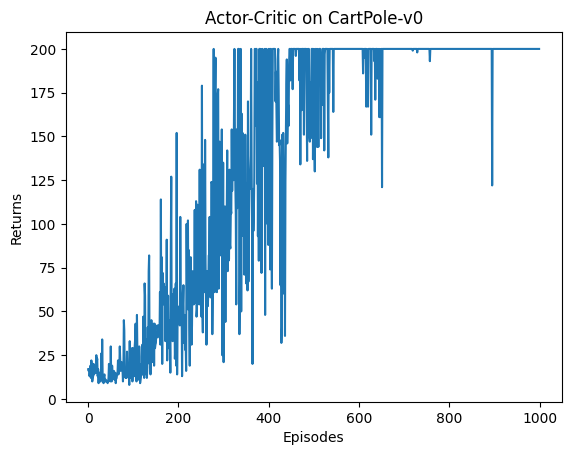

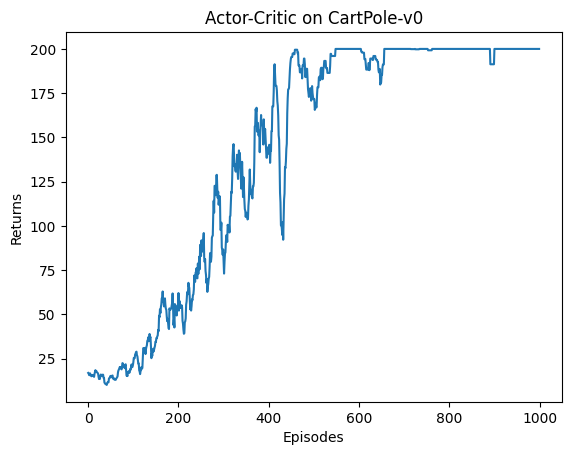

In [50]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

We can see that the actor-critic can converge quickly to optimality, and is more stable compared EINFORCE, inferring that the introduction reduces the variation.